In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

data = pd.read_csv('data/creditcard/creditcard.csv').drop_duplicates()

In [3]:
X = data.drop(['Class', 'Time'], axis=1)
y = data['Class']

In [4]:
X_train, X_test, y_train, y_true = train_test_split(
    X, y,
    test_size=.8,
    stratify=y,
    random_state=404
)

In [5]:
# For reduced data size:

selected_columns = [
    'V17',
    'V14',
    'V12',
    'V10',
    'V16',
    'V3',
    'V7',
    'V11',
    'V4',
    'V18',
    'V1',
    'V9',
    'V5',
    'V2',
]
X_train_reduced, X_test_reduced, y_train, y_true = train_test_split(
    X[selected_columns], y,
    test_size=.8,
    stratify=y,
    random_state=404
)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

In [7]:
# For Finding The Best Result
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

hpt_result = namedtuple('HyperparameterTuningResult', ['model', 'best_params', 'best_score', 'accuracy', 'fbeta'])

def evaluate_hpt(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=True):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return hpt_result(model, best_params, best_score, acc, fbeta)

def compare_models(new_results, old_results):
    is_improved = new_results.fbeta > old_results.fbeta
    print('-- HPT Evaluation --')
    print(f'{new_results.fbeta - old_results.fbeta = :.6f}', end='')
    print(' --> Improvement!') if is_improved else print(' --> Worsened!')
    print(f'{new_results.accuracy - old_results.accuracy = :.6f}', end='')
    print(' --> Improvement!') if new_results.accuracy > old_results.accuracy else print(' --> Worsened!')

    print(f'\nBest model so far:')
    best_results = new_results if is_improved else old_results
    best_model = f'{best_results.model.estimator} with Parameters\n{best_results.best_params}'
    best_score = new_results.fbeta if is_improved else old_results.fbeta
    print(f'{best_model}\nIts score: {best_score:.6f}')

    return best_model, best_score

BEST_MODEL = None
BEST_SCORE = None

--------------------------------------------------------------------------------

# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=404
).fit(X_train_scaled, y_train)

In [10]:
rf_pred = rf_model.predict(X_test_scaled)

In [11]:
print(f'{(rf_accuracy := accuracy_score(y_true, rf_pred)) = }')
print(f'{(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, rf_pred))

(rf_accuracy := accuracy_score(y_true, rf_pred)) = 0.9994492931126394
(rf_fbeta := fbeta_score(y_true, rf_pred, beta=beta, average=fbeta_average)) = 0.9994486977464869

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.89      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.95      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



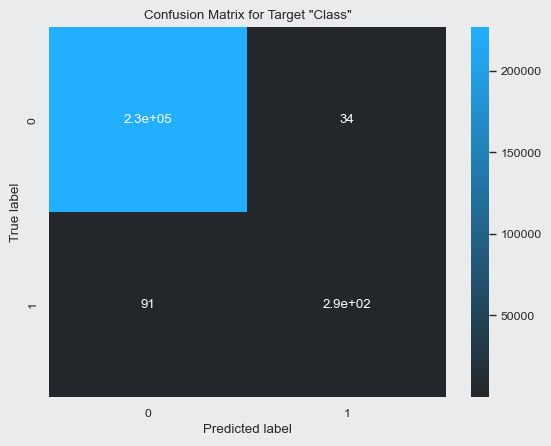

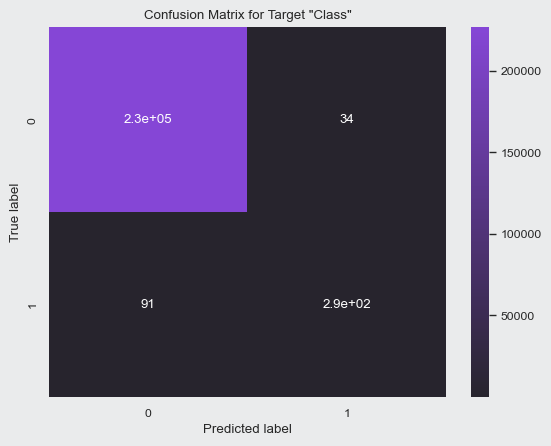

In [12]:
simple_confusion_matrix(y_true, rf_pred, 'Class')

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [13]:
rf_model_reduced = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=404
).fit(X_train_reduced_scaled, y_train)

rf_reduced_pred = rf_model_reduced.predict(X_test_reduced_scaled)

print(f'{(rf_reduced_accuracy := accuracy_score(y_true, rf_reduced_pred)) = }')
print(f'{(rf_reduced_fbeta := fbeta_score(y_true, rf_reduced_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, rf_reduced_pred))

(rf_reduced_accuracy := accuracy_score(y_true, rf_reduced_pred)) = 0.999427264837145
(rf_reduced_fbeta := fbeta_score(y_true, rf_reduced_pred, beta=beta, average=fbeta_average)) = 0.9994267742563695

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.88      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.94      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



In [14]:
print(f'Impact on the fbeta score: {rf_reduced_fbeta - rf_fbeta = :.6f}')
print('Improvement!') if rf_reduced_fbeta > rf_fbeta else print('Worsened!')

Impact on the fbeta score: rf_reduced_fbeta - rf_fbeta = -0.000022
Worsened!


## Hyperparameter Tuning

Official documentation for the `RandomForestClassifier`: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.

In [15]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [16]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 40, 60, None],         # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)  # for performance reasons, operate on selected columns exclusively

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=1.000 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.999 total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.999 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=1.0

In [24]:
rf_result = evaluate_hpt(
    model=rf_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	10
	n_estimators:	100
	n_jobs:	-1
	random_state:	404
Best Score:
	0.999435

-- Testing Results --
Accuracy    on Verification Data:	0.999445
Fbeta scroe on Verification Data:	0.999444

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.89      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.94      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981

False negatives: 90 (23.810% out of 378 attacks, 0.040% overall)



In [27]:
_ = evaluate_hpt(
    model=rf_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	criterion:	entropy
	max_depth:	10
	n_estimators:	100
	n_jobs:	-1
	random_state:	404
Best Score:
	0.999435

-- Testing Results --
Accuracy    on Verification Data:	0.999445
Fbeta scroe on Verification Data:	0.762984

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.89      0.76      0.82       378

    accuracy                           1.00    226981
   macro avg       0.94      0.88      0.91    226981
weighted avg       1.00      1.00      1.00    226981



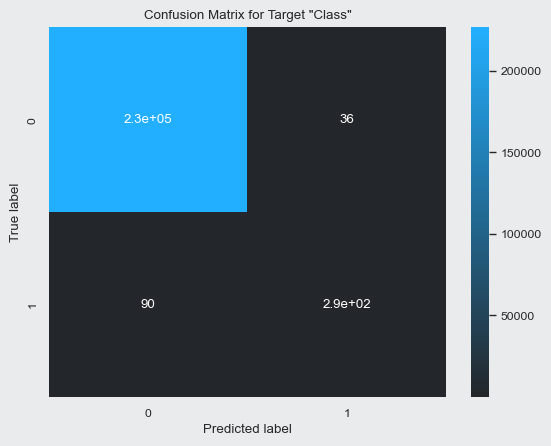

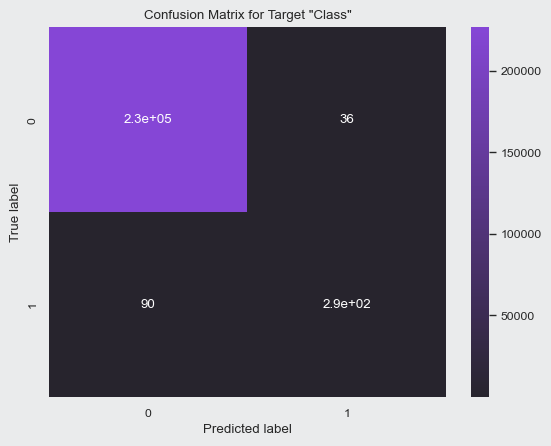

In [22]:
simple_confusion_matrix(y_true, rf_grid_search.predict(X_test_reduced_scaled), 'Class')

In [29]:
BEST_MODEL, BEST_SCORE = compare_models(rf_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.999444


--------------------------------------------------------------------------------

# KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=100).fit(X_train_scaled, y_train)

In [31]:
knn_pred = knn_model.predict(X_test_scaled)

In [32]:
print(f'{(knn_accuracy := accuracy_score(y_true, knn_pred)) = }')
print(f'{(knn_fbeta := fbeta_score(y_true, knn_pred, beta=beta, average=fbeta_average)) = }')
print(classification_report(y_true, knn_pred))

(knn_accuracy := accuracy_score(y_true, knn_pred)) = 0.9990219445680475
(knn_fbeta := fbeta_score(y_true, knn_pred, beta=beta, average=fbeta_average)) = 0.9990185571779026
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.85      0.50      0.63       378

    accuracy                           1.00    226981
   macro avg       0.93      0.75      0.81    226981
weighted avg       1.00      1.00      1.00    226981



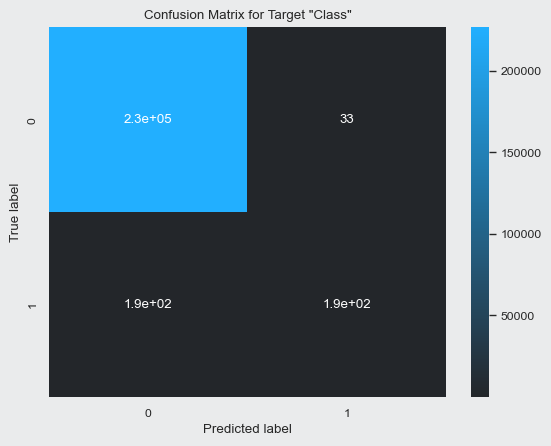

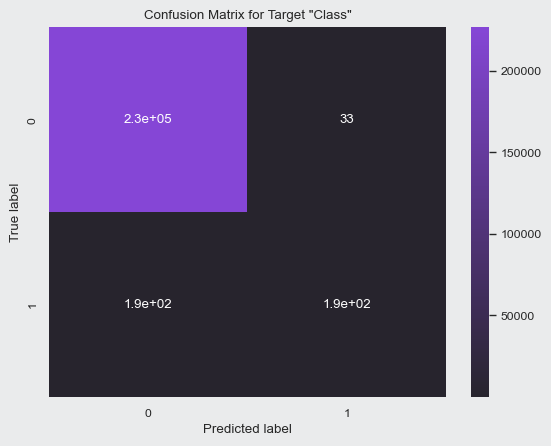

In [33]:
simple_confusion_matrix(y_true, knn_pred, 'Class')

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [34]:
knn_model_reduced = KNeighborsClassifier(
    n_neighbors=100
).fit(X_train_reduced_scaled, y_train)

knn_reduced_pred = knn_model_reduced.predict(X_test_reduced_scaled)

print(f'{(knn_reduced_accuracy := accuracy_score(y_true, knn_reduced_pred)) = }')
print(f'{(knn_reduced_fbeta := fbeta_score(y_true, knn_reduced_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, knn_reduced_pred))

(knn_reduced_accuracy := accuracy_score(y_true, knn_reduced_pred)) = 0.9990880293945308
(knn_reduced_fbeta := fbeta_score(y_true, knn_reduced_pred, beta=beta, average=fbeta_average)) = 0.9990853228496664

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.85      0.54      0.67       378

    accuracy                           1.00    226981
   macro avg       0.93      0.77      0.83    226981
weighted avg       1.00      1.00      1.00    226981



In [35]:
print(f'Impact on the fbeta score: {knn_reduced_fbeta - knn_fbeta = :.6f}')
print('Improvement!') if knn_reduced_fbeta > knn_fbeta else print('Worsened!')

Impact on the fbeta score: knn_reduced_fbeta - knn_fbeta = 0.000067
Improvement!


## Hyperparameter Tuning

In [36]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [37]:
knn_param_grid = {
    'n_neighbors': [5, 10, 20, 50, 100, 150],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
}
knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=1.000 total time=   0.6s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.999 total time=   0.5s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=1.000 total time=   0.5s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.999 total time=   0.5s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.999 total time=   0.5s
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=1.000 total time=   0.4s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.999 total time=   0.3s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=1.000 total time=   0.4s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.999 total time=   0.4s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.999 total time=   0.3s
[CV 1/5] END n_jobs=-1, n_neighbors=10, weights=unifor

In [38]:
knn_result = evaluate_hpt(
    model=knn_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	10
	weights:	uniform
Best Score:
	0.999400

-- Testing Results --
Accuracy    on Verification Data:	0.999361
Fbeta scroe on Verification Data:	0.999361

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.79      0.80       378

    accuracy                           1.00    226981
   macro avg       0.91      0.89      0.90    226981
weighted avg       1.00      1.00      1.00    226981

False negatives: 80 (21.164% out of 378 attacks, 0.035% overall)



In [39]:
_ = evaluate_hpt(
    model=knn_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	10
	weights:	uniform
Best Score:
	0.999400

-- Testing Results --
Accuracy    on Verification Data:	0.999361
Fbeta scroe on Verification Data:	0.788670

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.79      0.80       378

    accuracy                           1.00    226981
   macro avg       0.91      0.89      0.90    226981
weighted avg       1.00      1.00      1.00    226981



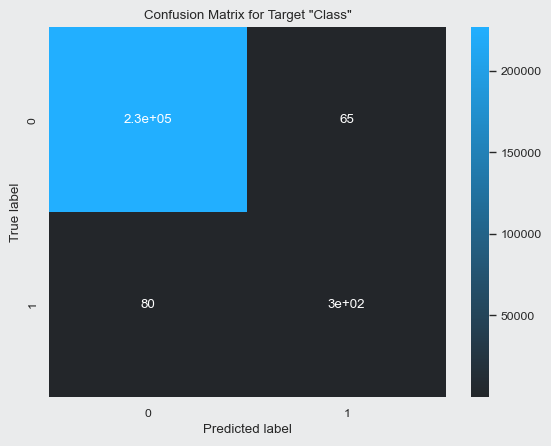

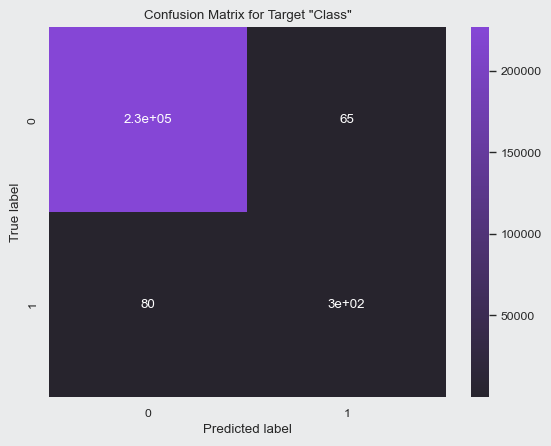

In [40]:
simple_confusion_matrix(y_true, knn_grid_search.predict(X_test_reduced_scaled), 'Class')

In [41]:
BEST_MODEL, BEST_SCORE = compare_models(knn_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.000083 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000084 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.999444


--------------------------------------------------------------------------------

# Naive Bayes

In [42]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB().fit(X_train_scaled, y_train)

In [43]:
gnb_pred = gnb_model.predict(X_test_scaled)

In [44]:
print(f'{(gnb_accuracy := accuracy_score(y_true, gnb_pred)) = }')
print(f'{(gnb_fbeta := fbeta_score(y_true, gnb_pred, beta=beta, average=fbeta_average)) = }')
print(classification_report(y_true, gnb_pred))

(gnb_accuracy := accuracy_score(y_true, gnb_pred)) = 0.9768482824553597
(gnb_fbeta := fbeta_score(y_true, gnb_pred, beta=beta, average=fbeta_average)) = 0.976900099906341
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    226603
           1       0.06      0.85      0.11       378

    accuracy                           0.98    226981
   macro avg       0.53      0.91      0.55    226981
weighted avg       1.00      0.98      0.99    226981



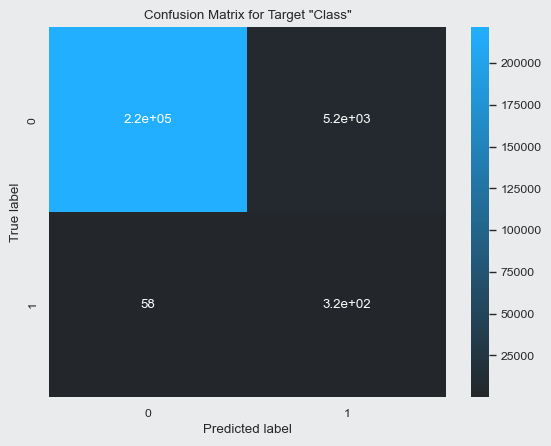

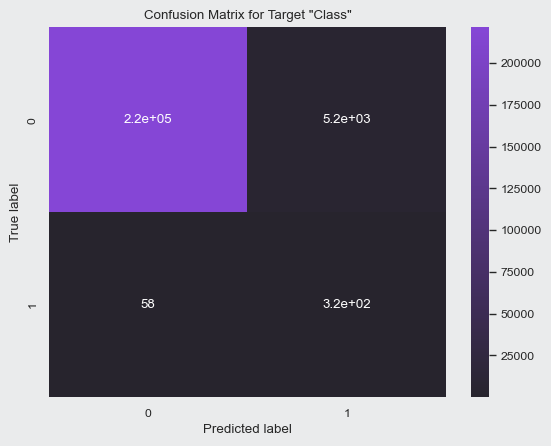

In [46]:
simple_confusion_matrix(y_true, gnb_pred, 'Class')

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [47]:
gnb_model_reduced = GaussianNB().fit(X_train_reduced_scaled, y_train)

gnb_reduced_pred = gnb_model_reduced.predict(X_test_reduced_scaled)

print(f'{(gnb_reduced_accuracy := accuracy_score(y_true, gnb_reduced_pred)) = }')
print(f'{(gnb_reduced_fbeta := fbeta_score(y_true, gnb_reduced_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, gnb_reduced_pred))

(gnb_reduced_accuracy := accuracy_score(y_true, gnb_reduced_pred)) = 0.9859591771998537
(gnb_reduced_fbeta := fbeta_score(y_true, gnb_reduced_pred, beta=beta, average=fbeta_average)) = 0.9859863425482949

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226603
           1       0.09      0.85      0.17       378

    accuracy                           0.99    226981
   macro avg       0.55      0.92      0.58    226981
weighted avg       1.00      0.99      0.99    226981



In [48]:
print(f'Impact on the fbeta score: {gnb_reduced_fbeta - gnb_fbeta = :.6f}')
print('Improvement!') if gnb_reduced_fbeta > gnb_fbeta else print('Worsened!')

Impact on the fbeta score: gnb_reduced_fbeta - gnb_fbeta = 0.009086
Improvement!


## Hyperparameter Tuning

In [49]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [50]:
rel_positive = len(y[y==1]) / len(y)
gnb_param_grid = {
    'priors': [None, [1 - rel_positive, rel_positive]]
}
gnb_grid_search = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=gnb_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .......................priors=None;, score=0.984 total time=   0.0s
[CV 2/5] END .......................priors=None;, score=0.986 total time=   0.0s
[CV 3/5] END .......................priors=None;, score=0.986 total time=   0.0s
[CV 4/5] END .......................priors=None;, score=0.987 total time=   0.0s
[CV 5/5] END .......................priors=None;, score=0.987 total time=   0.0s
[CV 1/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.984 total time=   0.0s
[CV 2/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.986 total time=   0.0s
[CV 3/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.986 total time=   0.0s
[CV 4/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.987 total time=   0.0s
[CV 5/5] END priors=[0.9983328986416472, 0.001667101358352777];, score=0.987 total time=   0.0s


In [52]:
gnb_result = evaluate_hpt(
    model=gnb_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.986139

-- Testing Results --
Accuracy    on Verification Data:	0.985959
Fbeta scroe on Verification Data:	0.985986

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226603
           1       0.09      0.85      0.17       378

    accuracy                           0.99    226981
   macro avg       0.55      0.92      0.58    226981
weighted avg       1.00      0.99      0.99    226981

False negatives: 58 (15.344% out of 378 attacks, 0.026% overall)



In [53]:
_ = evaluate_hpt(
    model=gnb_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	priors:	None
Best Score:
	0.986139

-- Testing Results --
Accuracy    on Verification Data:	0.985959
Fbeta scroe on Verification Data:	0.783534

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    226603
           1       0.09      0.85      0.17       378

    accuracy                           0.99    226981
   macro avg       0.55      0.92      0.58    226981
weighted avg       1.00      0.99      0.99    226981



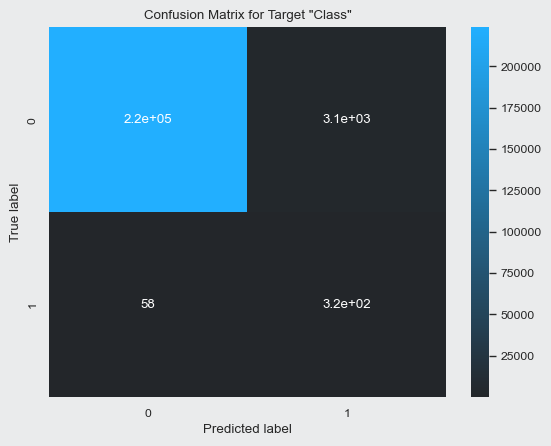

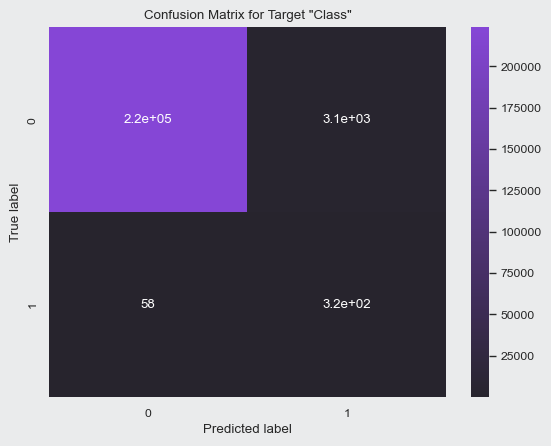

In [54]:
simple_confusion_matrix(y_true, gnb_grid_search.predict(X_test_reduced_scaled), 'Class')

In [55]:
BEST_MODEL, BEST_SCORE = compare_models(gnb_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.013458 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.013486 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.999444


--------------------------------------------------------------------------------

# Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000).fit(X_train_scaled, y_train)

In [58]:
lr_pred = lr_model.predict(X_test_scaled)

In [59]:
print(f'{(lr_accuracy := accuracy_score(y_true, lr_pred)) = }')
print(f'{(lr_fbeta := fbeta_score(y_true, lr_pred, beta=beta, average=fbeta_average)) = }')
print(classification_report(y_true, lr_pred))

(lr_accuracy := accuracy_score(y_true, lr_pred)) = 0.999193765116904
(lr_fbeta := fbeta_score(y_true, lr_pred, beta=beta, average=fbeta_average)) = 0.9991925763374309
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.83      0.65      0.73       378

    accuracy                           1.00    226981
   macro avg       0.91      0.83      0.86    226981
weighted avg       1.00      1.00      1.00    226981



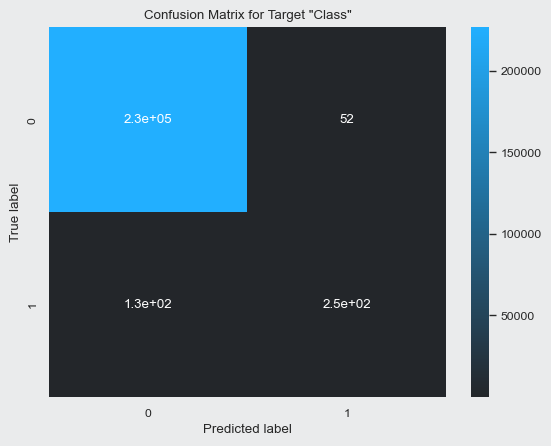

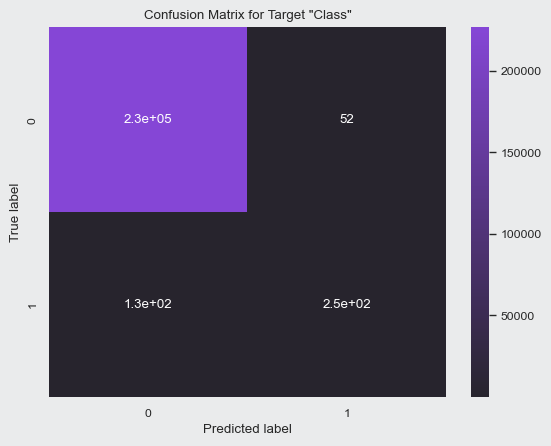

In [60]:
simple_confusion_matrix(y_true, lr_pred, 'Class')

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [61]:
lr_model_reduced = LogisticRegression(
    max_iter=1000
).fit(X_train_reduced_scaled, y_train)

lr_reduced_pred = lr_model_reduced.predict(X_test_reduced_scaled)

print(f'{(lr_reduced_accuracy := accuracy_score(y_true, lr_reduced_pred)) = }')
print(f'{(lr_reduced_fbeta := fbeta_score(y_true, lr_reduced_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, lr_reduced_pred))

(lr_reduced_accuracy := accuracy_score(y_true, lr_reduced_pred)) = 0.9992554442882885
(lr_reduced_fbeta := fbeta_score(y_true, lr_reduced_pred, beta=beta, average=fbeta_average)) = 0.9992541260827029

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.86      0.66      0.75       378

    accuracy                           1.00    226981
   macro avg       0.93      0.83      0.87    226981
weighted avg       1.00      1.00      1.00    226981



In [62]:
print(f'Impact on the fbeta score: {lr_reduced_fbeta - lr_fbeta = :.6f}')
print('Improvement!') if lr_reduced_fbeta > lr_fbeta else print('Worsened!')

Impact on the fbeta score: lr_reduced_fbeta - lr_fbeta = 0.000062
Improvement!


## Hyperparameter Tuning

In [63]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [64]:
import warnings
warnings.filterwarnings('ignore')

In [65]:
lr_param_grid = {
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5, 1.e-6],
    'C': [0.4 + 0.2*n for n in range(6)],
    'fit_intercept': [True, False],
    'max_iter': [7500],
    'n_jobs': [-1],
    'random_state': [404],
}
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=lr_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.999 total time=   2.7s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.999 total time=   0.5s
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=1.000 total time=   0.5s
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.999 total time=   0.5s
[CV 5/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.999 total time=   0.5s
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.999 total time=   1.2s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=7500, n_jobs=-1, penalty=l2, random_state=404, tol

In [66]:
lr_result = evaluate_hpt(
    model=lr_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	max_iter:	7500
	n_jobs:	-1
	penalty:	None
	random_state:	404
	tol:	1e-06
Best Score:
	0.999329

-- Testing Results --
Accuracy    on Verification Data:	0.999251
Fbeta scroe on Verification Data:	0.999250

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.86      0.66      0.74       378

    accuracy                           1.00    226981
   macro avg       0.93      0.83      0.87    226981
weighted avg       1.00      1.00      1.00    226981

False negatives: 130 (34.392% out of 378 attacks, 0.057% overall)



In [67]:
_ = evaluate_hpt(
    model=lr_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	True
	max_iter:	7500
	n_jobs:	-1
	penalty:	None
	random_state:	404
	tol:	1e-06
Best Score:
	0.999329

-- Testing Results --
Accuracy    on Verification Data:	0.999251
Fbeta scroe on Verification Data:	0.657635

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.86      0.66      0.74       378

    accuracy                           1.00    226981
   macro avg       0.93      0.83      0.87    226981
weighted avg       1.00      1.00      1.00    226981



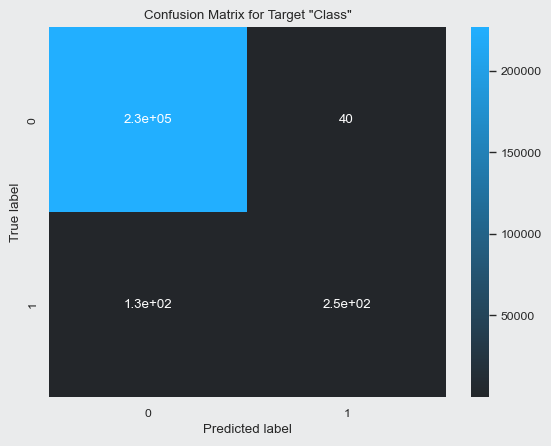

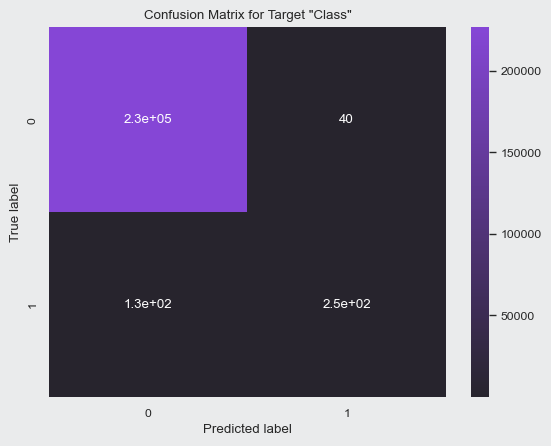

In [68]:
simple_confusion_matrix(y_true, lr_grid_search.predict(X_test_reduced_scaled), 'Class')

In [69]:
BEST_MODEL, BEST_SCORE = compare_models(lr_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.000195 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000194 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.999444


--------------------------------------------------------------------------------

# Support Vector Machine

In [70]:
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', C=1.).fit(X_train_scaled, y_train)

In [71]:
svc_pred = svc_model.predict(X_test_scaled)

In [72]:
print(f'{(svc_accuracy := accuracy_score(y_true, svc_pred)) = }')
print(f'{(svc_fbeta := fbeta_score(y_true, svc_pred, beta=beta, average=fbeta_average)) = }')
print(classification_report(y_true, svc_pred))

(svc_accuracy := accuracy_score(y_true, svc_pred)) = 0.9993171234596728
(svc_fbeta := fbeta_score(y_true, svc_pred, beta=beta, average=fbeta_average)) = 0.9993167151577527
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.83      0.75      0.78       378

    accuracy                           1.00    226981
   macro avg       0.91      0.87      0.89    226981
weighted avg       1.00      1.00      1.00    226981



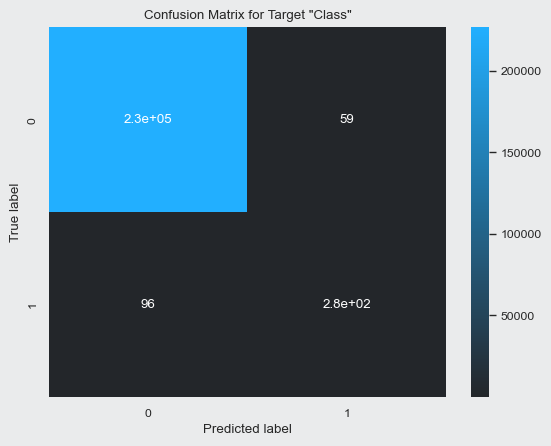

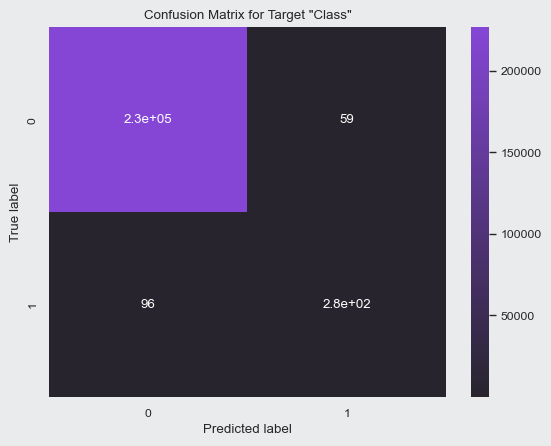

In [73]:
simple_confusion_matrix(y_true, svc_pred, 'Class')

## Comparison with Reduced Dataset

For this run, we will use a subset of the features. The selected columns have been
chosen after the initial EDA with an absolute correlation value of at least 0.05.

In [74]:
svc_model_reduced = SVC(
    kernel='linear',
    C=1.
).fit(X_train_reduced_scaled, y_train)

svc_reduced_pred = svc_model_reduced.predict(X_test_reduced_scaled)

print(f'{(svc_reduced_accuracy := accuracy_score(y_true, svc_reduced_pred)) = }')
print(f'{(svc_reduced_fbeta := fbeta_score(y_true, svc_reduced_pred, beta=beta, average=fbeta_average)) = }\n')
print(classification_report(y_true, svc_reduced_pred))

(svc_reduced_accuracy := accuracy_score(y_true, svc_reduced_pred)) = 0.9993699913208595
(svc_reduced_fbeta := fbeta_score(y_true, svc_reduced_pred, beta=beta, average=fbeta_average)) = 0.9993698746238273

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.79      0.81       378

    accuracy                           1.00    226981
   macro avg       0.91      0.90      0.90    226981
weighted avg       1.00      1.00      1.00    226981



In [75]:
print(f'Impact on the fbeta score: {svc_reduced_fbeta - svc_fbeta = :.6f}')
print('Improvement!') if svc_reduced_fbeta > svc_fbeta else print('Worsened!')

Impact on the fbeta score: svc_reduced_fbeta - svc_fbeta = 0.000053
Improvement!


## Hyperparameter Tuning

In [76]:
beta = 10
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

In [77]:
svc_param_grid = {
    'C': [0.4 + 0.2*n for n in range(6)],
    #'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [3, len(selected_columns)],
    'gamma': ['scale', 'auto'],
    'tol': [1.e-3, 1.e-5, 1.e-6],
    'max_iter': [10_000],
    'random_state': [404]
}
svc_grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=svc_param_grid,
    refit=True,
    verbose=3,
    scoring=f10_scorer
).fit(X_train_reduced_scaled, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=1.000 total time=   0.8s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.999 total time=   0.7s
[CV 3/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=1.000 total time=   0.6s
[CV 4/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.999 total time=   0.5s
[CV 5/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=0.001;, score=0.999 total time=   0.7s
[CV 1/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=1.000 total time=   0.8s
[CV 2/5] END C=0.4, degree=3, gamma=scale, kernel=linear, max_iter=10000, random_state=404, tol=1e-05;, score=0.999 total time

In [78]:
svc_result = evaluate_hpt(
    model=svc_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average=fbeta_average
)

-- Training Results --
Best Parameters:
	C:	1.0
	degree:	3
	gamma:	scale
	kernel:	linear
	max_iter:	10000
	random_state:	404
	tol:	0.001
Best Score:
	0.999400

-- Testing Results --
Accuracy    on Verification Data:	0.999366
Fbeta scroe on Verification Data:	0.999365

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.80      0.81       378

    accuracy                           1.00    226981
   macro avg       0.91      0.90      0.90    226981
weighted avg       1.00      1.00      1.00    226981

False negatives: 77 (20.370% out of 378 attacks, 0.034% overall)



In [79]:
_ = evaluate_hpt(
    model=svc_grid_search,
    X_test=X_test_reduced_scaled,
    y_true=y_true,
    beta=beta,
    average='binary',
    display_false_negatives=False
)

-- Training Results --
Best Parameters:
	C:	1.0
	degree:	3
	gamma:	scale
	kernel:	linear
	max_iter:	10000
	random_state:	404
	tol:	0.001
Best Score:
	0.999400

-- Testing Results --
Accuracy    on Verification Data:	0.999366
Fbeta scroe on Verification Data:	0.796505

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226603
           1       0.82      0.80      0.81       378

    accuracy                           1.00    226981
   macro avg       0.91      0.90      0.90    226981
weighted avg       1.00      1.00      1.00    226981



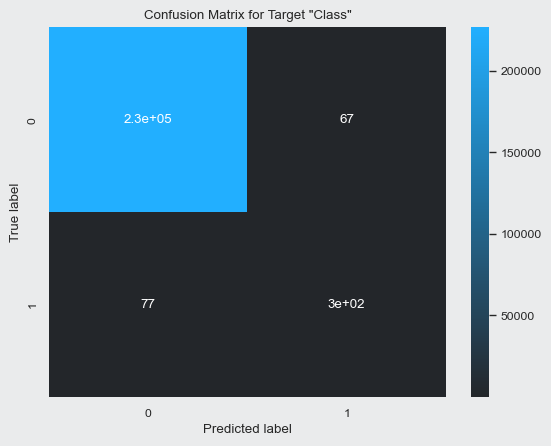

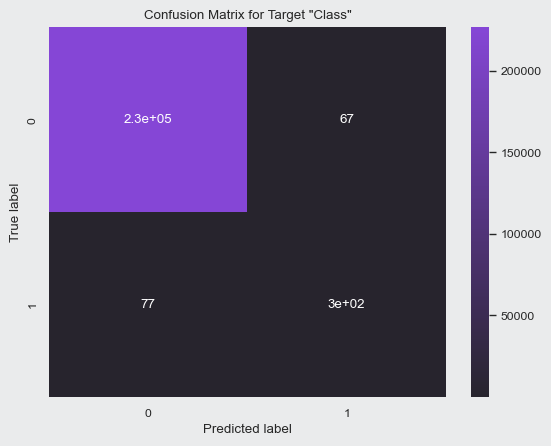

In [80]:
simple_confusion_matrix(y_true, svc_grid_search.predict(X_test_reduced_scaled), 'Class')

In [81]:
BEST_MODEL, BEST_SCORE = compare_models(svc_result, rf_result)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.000079 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000079 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 404}
Its score: 0.999444
